In [1]:
# data
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp

# system
import os
import time
from os.path import join

# stats
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import itertools
from gprofiler import GProfiler
import submitit
import itertools

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

from scTRS.method import get_p_from_empi_null
# gene_score should go utils
from IPython.display import Markdown, display


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 leidenalg==0.8.2


In [2]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
GENE_SCORE_PATH = join(DATA_PATH, 'trs_gene_scores')
hsapiens_mmusculus_mapping = pd.read_csv(join(GENE_SCORE_PATH, 'meta_data', 'hsapiens_mmusculus_mapping.csv'))

dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
hsapiens_genes = list(set(hsapiens_mmusculus_mapping['mmusculus'].values) & set(data_facs_ct.var_names))
data_facs_ct = data_facs_ct[:, hsapiens_genes].copy()
md.compute_stats(data_facs_ct)

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


Trying to set attribute `.obs` of view, copying.


In [42]:
def _compute_trs(adata, gene_list, gene_weight):

    gene_list = list(gene_list)
    # the gene_weight includes both vst weight and user-specified weights.
    gene_weight /= gene_weight.sum()
    temp_v = adata[:, gene_list].X.dot(gene_weight) - adata[:, gene_list].var['gene_mean'].dot(gene_weight)
#     temp_v = adata[:, gene_list].X.dot(gene_weight)
    v_trs = np.array(temp_v, dtype=np.float64).reshape([-1])
        
    return v_trs

def _select_ctrl_genes(trait_genes, all_gene_df, bin_name, num_ctrls, num_bins=200):
    # calculate the bin statistics
    df = all_gene_df[[bin_name]].reset_index().rename(columns={'index': 'gene', bin_name: 'value'}).copy()
    df['bin'] = pd.qcut(df['value'], q=num_bins, duplicates='drop')
    df = df.groupby('bin').agg({'gene': set})
    
    # calculate number of overlap
    overlap_num = df['gene'].apply(lambda x: len(x & set(trait_genes)))

    ctrl_genes = [[] for i in range(num_ctrls)]
    for index, row in df.iterrows():
        for ctrl_i in range(num_ctrls):
            ctrl_genes[ctrl_i].extend(np.random.choice(list(row['gene']), size=overlap_num[index], replace=False))
    return ctrl_genes

def demo(dataset, gene_weight, permutation_weight, gene_list):
    """
    dataset: for what dataset to derive TRS [all, random, liver]
    gene_weight: use what kind of gene weights [all, subset]
    permutation_gene: how to select the genes for permutation [random, whole_mean_match, subset_mean_match, whole_weighted_mean_match, subset_weighted_mean_match]
    permutation_weight: how the weight for permutation genes is set [trait, own]
    
    """
    np.random.seed(1234)
    DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
    GENE_SCORE_PATH = join(DATA_PATH, 'trs_gene_scores')
    hsapiens_mmusculus_mapping = pd.read_csv(join(GENE_SCORE_PATH, 'meta_data', 'hsapiens_mmusculus_mapping.csv'))
    
    
    data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
    hsapiens_genes = list(set(hsapiens_mmusculus_mapping['mmusculus'].values) & set(data_facs_ct.var_names))
    data_facs_ct = data_facs_ct[:, hsapiens_genes].copy()
    md.compute_stats(data_facs_ct)
    
    if dataset == 'all':
        adata = data_facs_ct.copy()
    elif dataset == 'random':
        adata = data_facs_ct[np.random.choice(data_facs_ct.obs.index, size=3000, replace=False)].copy()
    elif dataset == 'liver':
        adata = data_facs_ct[data_facs_ct.obs['tissue'] == 'Liver'].copy()
    else:
        raise NotImplementedError
    md.compute_stats(adata)
    
    all_gene_df = pd.concat([data_facs_ct.var[['mean', 'var', 'var_tech']].rename(columns={'mean': 'all_mean', 
                                                                                           'var': 'all_var', 
                                                                                           'var_tech': 'all_var_tech'}),
                             adata.var[['mean', 'var', 'var_tech']].rename(columns={'mean': 'subset_mean', 
                                                                                    'var': 'subset_var', 
                                                                                    'var_tech': 'subset_var_tech'})], axis=1)
    if gene_weight == 'all':
        all_gene_df['weight'] = 1. / np.sqrt(all_gene_df['all_var_tech'].values.clip(min=1e-2))
        adata.var['gene_mean'] = all_gene_df['all_mean']
        ctrl_bin_name = 'all_mean'
    elif gene_weight == 'subset':
        all_gene_df['weight'] = 1. / np.sqrt(all_gene_df['subset_var_tech'].values.clip(min=1e-2))
        adata.var['gene_mean'] = all_gene_df['subset_mean']
        ctrl_bin_name = 'subset_mean'
    else:
        raise NotImplementedError
    
    # construct trait_gene_df and control_gene_df
    trait_gene_df = all_gene_df.reindex(gene_list).dropna()
    
    num_ctrls = 500
    
    ctrl_genes_list = _select_ctrl_genes(gene_list, all_gene_df, bin_name=ctrl_bin_name, num_ctrls=num_ctrls)
    ctrl_gene_df_list = [all_gene_df[['weight']].loc[ctrl_genes, :].copy() for ctrl_genes in ctrl_genes_list]

    # compute TRS for both trait gene set and control gene sets
    trait_trs = _compute_trs(adata, trait_gene_df.index.values, trait_gene_df.weight.values)

    ctrl_trs_list = []
    for ctrl_gene_df in ctrl_gene_df_list: 
        ctrl_trs_list.append(_compute_trs(adata, ctrl_gene_df.index.values, ctrl_gene_df.weight.values))
    ctrl_trs = np.vstack(ctrl_trs_list)
    ctrl_trs_mean, ctrl_trs_sd = np.mean(ctrl_trs, axis=0), np.std(ctrl_trs, axis=0)
    trait_zsc = (trait_trs - ctrl_trs_mean) / ctrl_trs_sd
    ctrl_zsc = (ctrl_trs - ctrl_trs_mean) / ctrl_trs_sd
    trait_ep = get_p_from_empi_null(trait_zsc, ctrl_zsc.flatten())  
    # background correction
    return {'trait_trs': trait_trs,
            'ctrl_trs_mean': ctrl_trs_mean,
            'ctrl_trs_sd': ctrl_trs_sd,
            'pval': (np.sum(trait_trs < ctrl_trs, axis=0) + 1) / (num_ctrls + 1),
            'trait_ep': trait_ep}
#     return np.mean(trait_trs < np.vstack(ctrl_trs_list), axis=0)
#     return {'trait_trs': trait_trs,
#             'ctrl_trs_list': ctrl_trs_list,
#             'pval': np.mean(trait_trs < ctrl_trs, axis=0)}

# Simulation study

In [43]:
import submitit
executor = submitit.AutoExecutor(folder="~/submitit_log/")
executor.update_parameters(timeout_min=25, mem_gb=20, slurm_partition="shared")

np.random.seed(1234)

gene_set_dict = {}
num_sim = 5
for i in range(num_sim):
    gene_set_dict[f'random_{i}'] = np.unique(np.random.choice(data_facs_ct.var_names, size=500, replace=False))

for i in range(num_sim):
    gene_set_dict[f'low_{i}'] = np.unique(np.random.choice(data_facs_ct.var['mean'].nsmallest(3000).index, size=500, replace=False))

for i in range(num_sim):
    gene_set_dict[f'high_{i}'] = np.unique(np.random.choice(data_facs_ct.var['mean'].nlargest(3000).index, size=500, replace=False))

job_dict = {name: executor.submit(demo, 'all', 'all', 'own', gene_set_dict[name]) for name in gene_set_dict}

In [49]:
job_dict

{'random_0': SlurmJob<job_id=9999338, task_id=0, state="COMPLETED">,
 'random_1': SlurmJob<job_id=9999344, task_id=0, state="COMPLETED">,
 'random_2': SlurmJob<job_id=9999347, task_id=0, state="COMPLETED">,
 'random_3': SlurmJob<job_id=9999353, task_id=0, state="COMPLETED">,
 'random_4': SlurmJob<job_id=9999354, task_id=0, state="COMPLETED">,
 'low_0': SlurmJob<job_id=9999356, task_id=0, state="COMPLETED">,
 'low_1': SlurmJob<job_id=9999360, task_id=0, state="COMPLETED">,
 'low_2': SlurmJob<job_id=9999364, task_id=0, state="COMPLETED">,
 'low_3': SlurmJob<job_id=9999366, task_id=0, state="COMPLETED">,
 'low_4': SlurmJob<job_id=9999371, task_id=0, state="COMPLETED">,
 'high_0': SlurmJob<job_id=9999374, task_id=0, state="COMPLETED">,
 'high_1': SlurmJob<job_id=9999377, task_id=0, state="COMPLETED">,
 'high_2': SlurmJob<job_id=9999378, task_id=0, state="COMPLETED">,
 'high_3': SlurmJob<job_id=9999379, task_id=0, state="COMPLETED">,
 'high_4': SlurmJob<job_id=9999380, task_id=0, state="COM

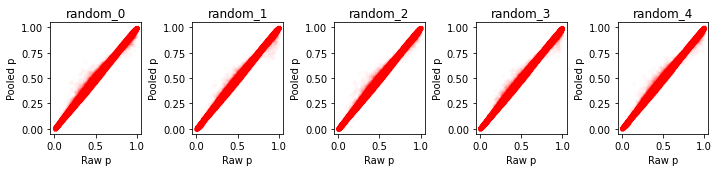

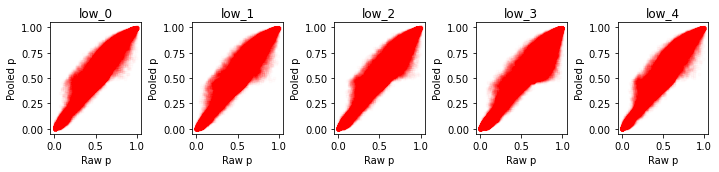

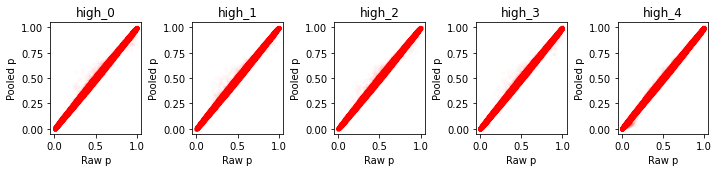

In [50]:
for group in ['random', 'low', 'high']:
    
    plt.figure(figsize=(10, 2.5))
    for rep_i in range(num_sim):
        trait = f'{group}_{rep_i}'
        rls = job_dict[trait].result()
        plt.subplot(1, num_sim, rep_i + 1)
        plt.plot(rls['pval'], rls['trait_ep'], 'r.', alpha=0.01)
        plt.xlabel('Raw p')
        plt.ylabel('Pooled p')
        plt.title(trait)
    plt.tight_layout()
    plt.show()

## random

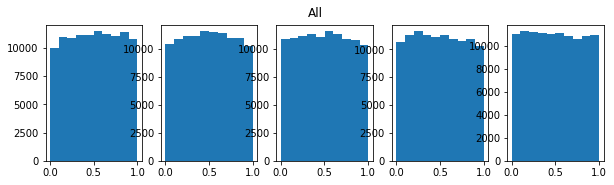

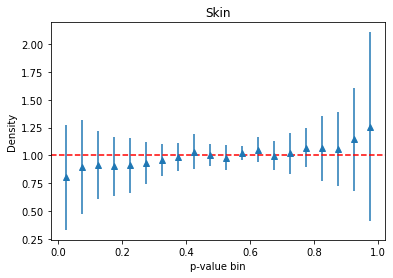

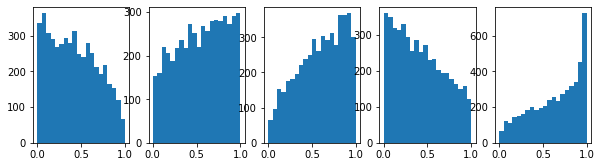

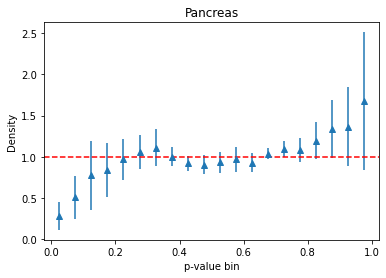

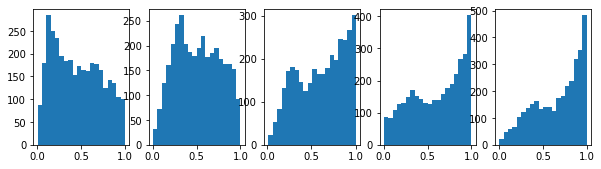

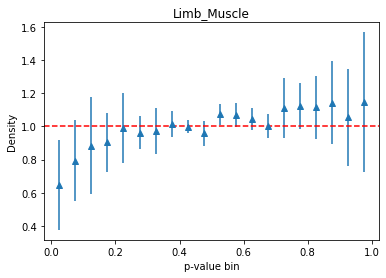

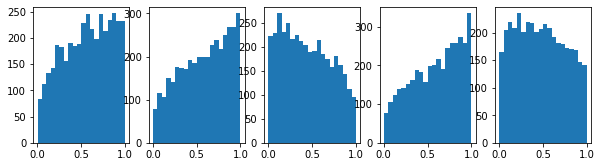

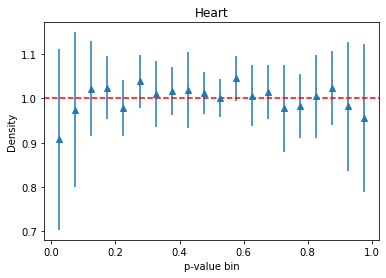

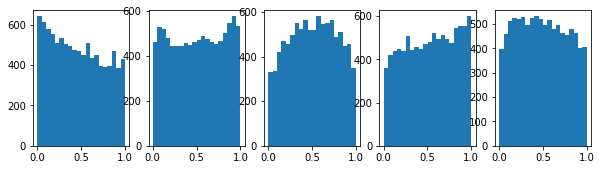

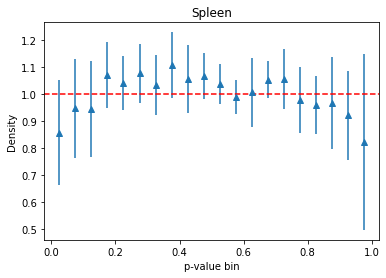

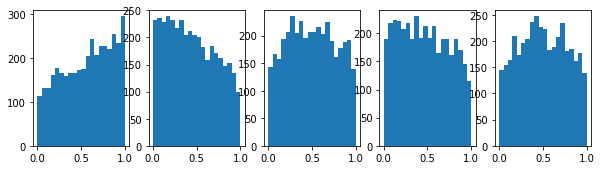

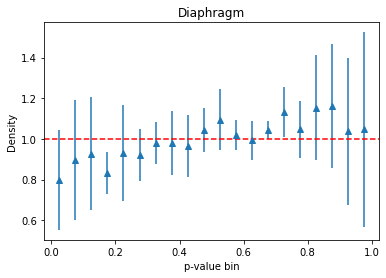

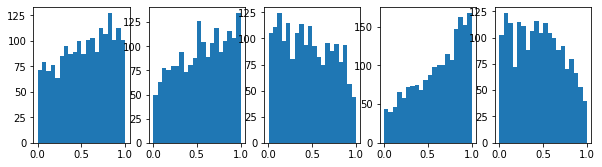

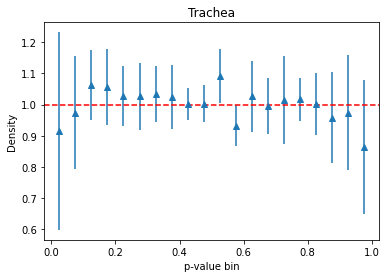

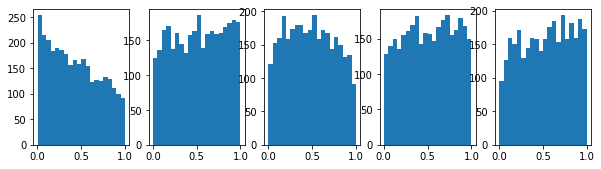

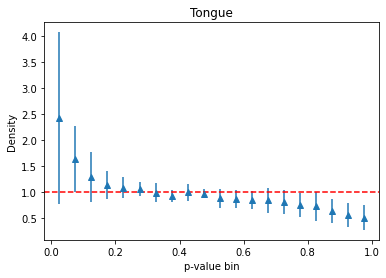

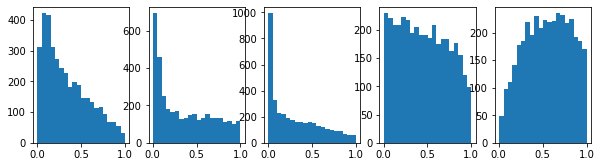

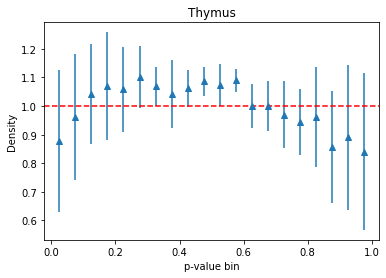

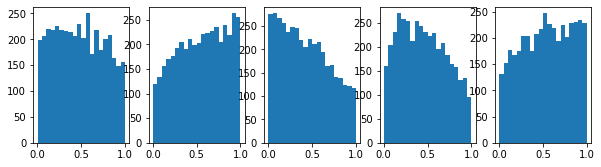

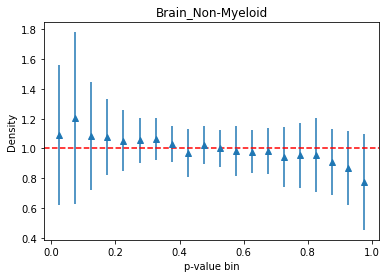

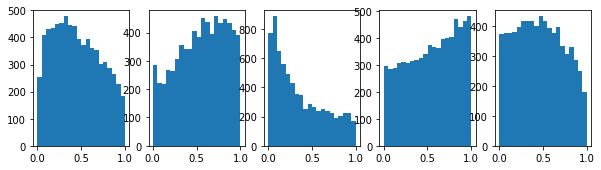

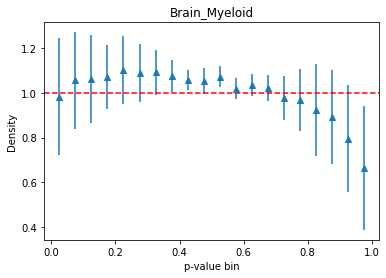

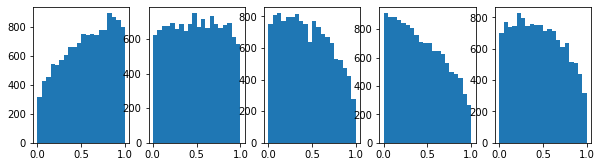

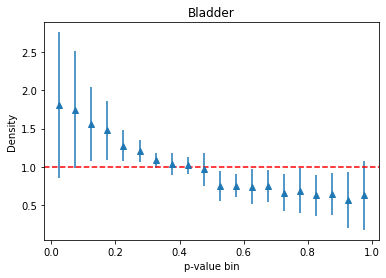

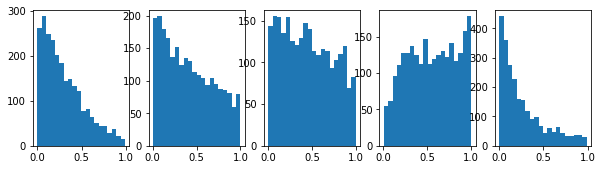

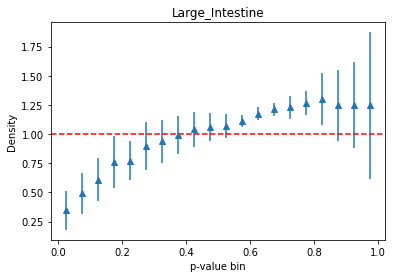

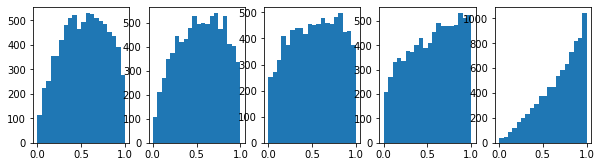

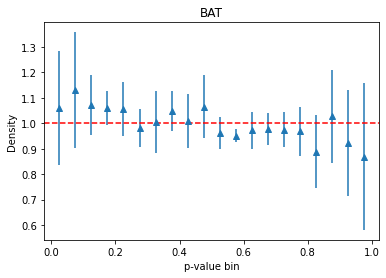

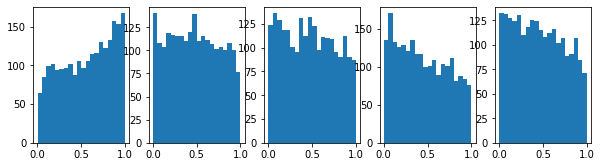

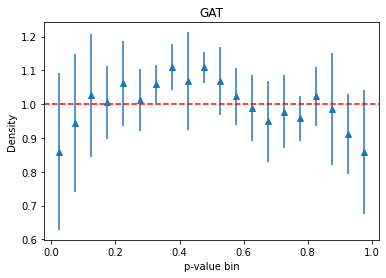

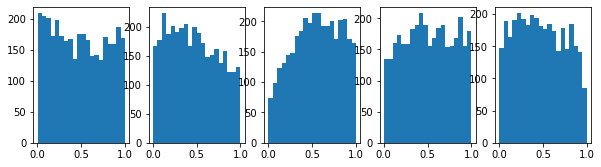

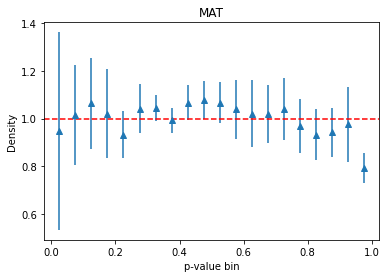

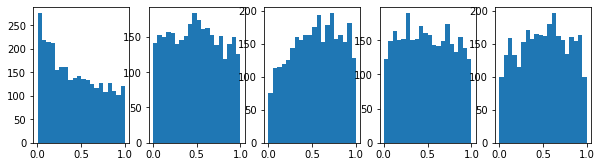

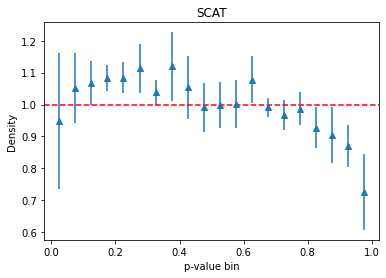

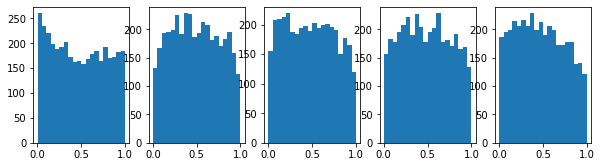

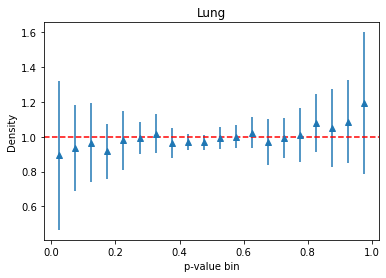

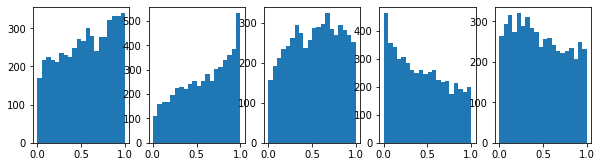

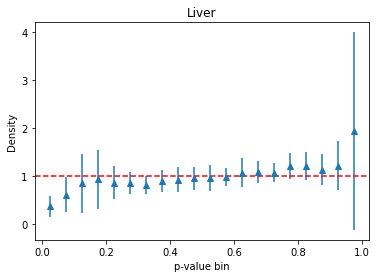

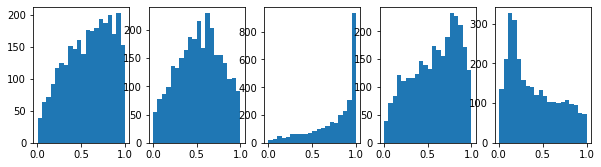

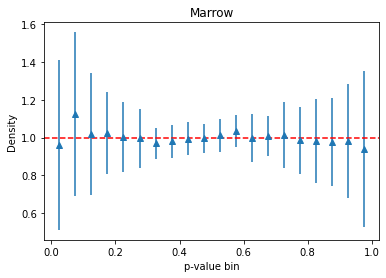

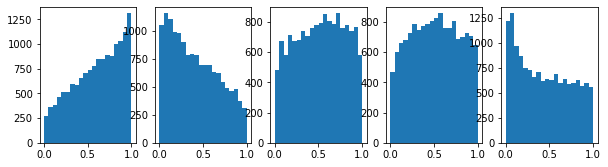

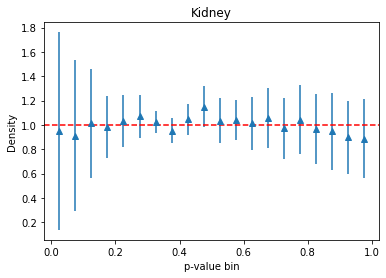

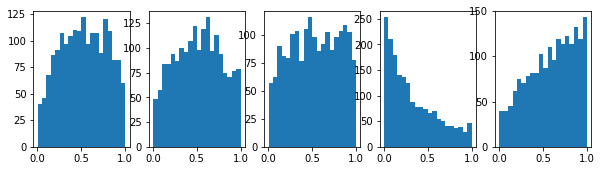

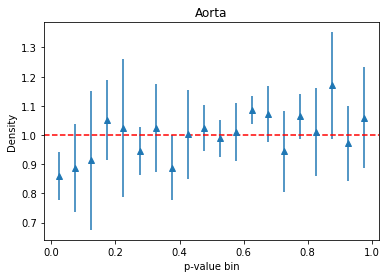

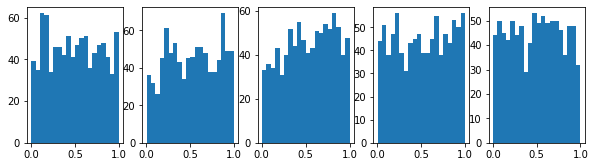

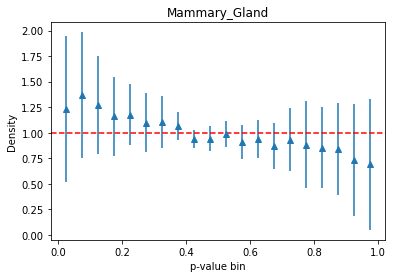

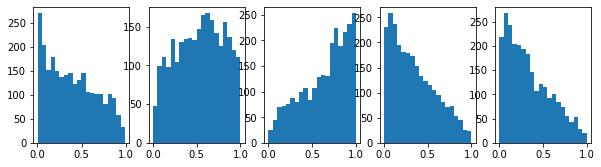

## low

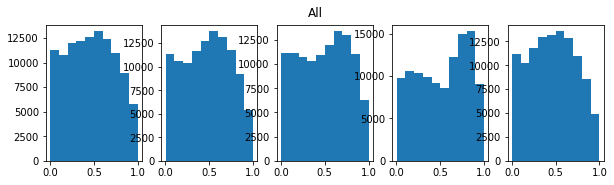

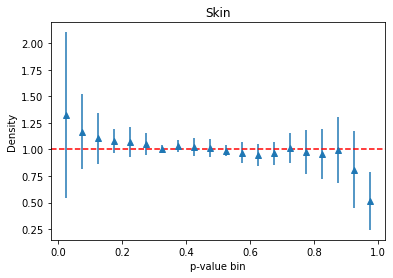

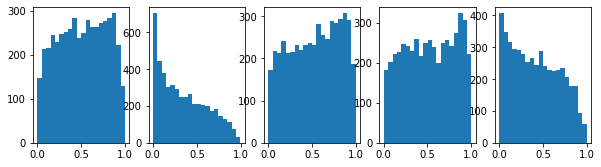

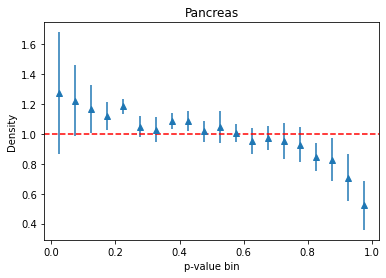

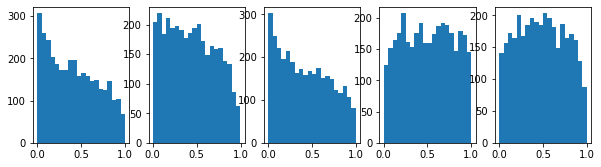

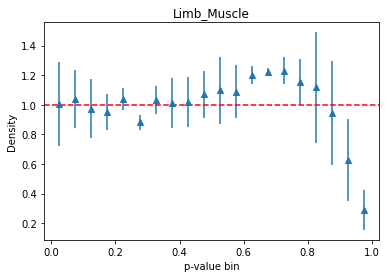

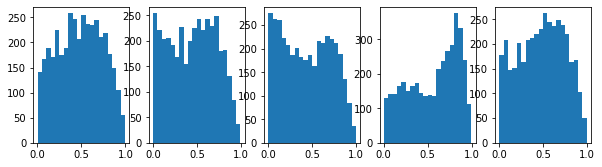

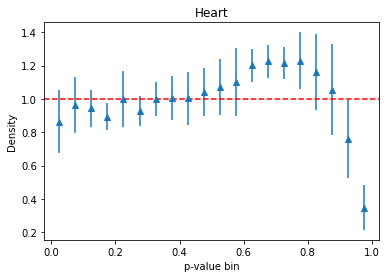

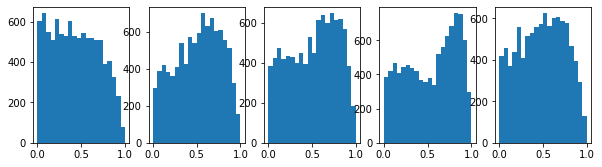

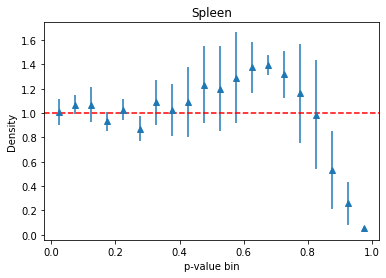

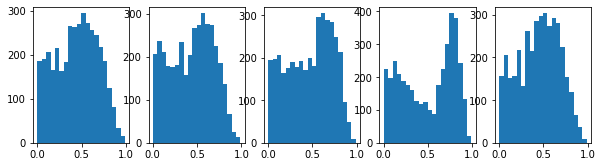

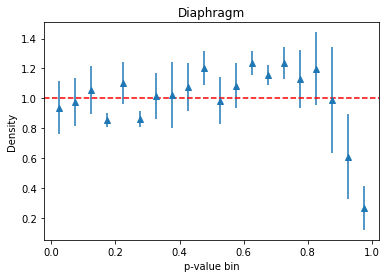

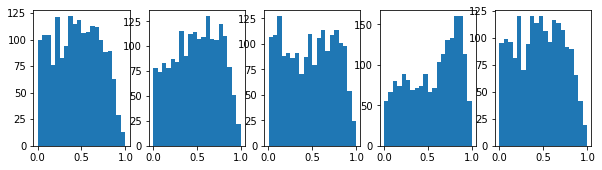

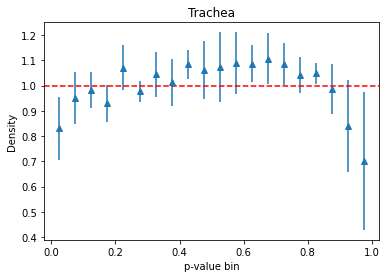

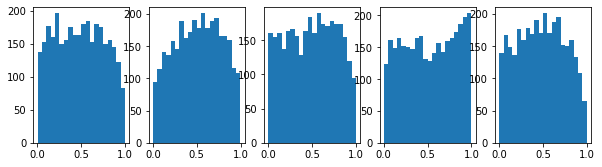

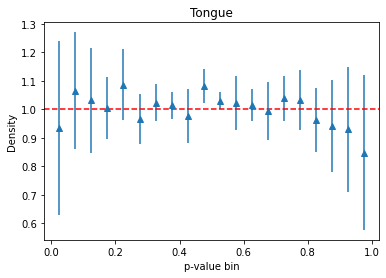

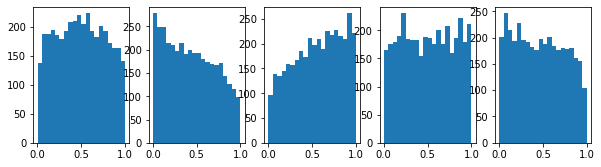

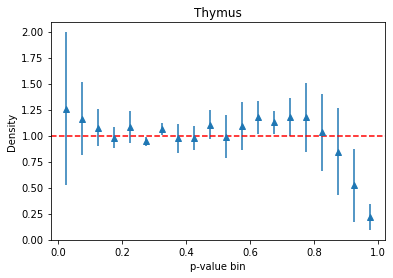

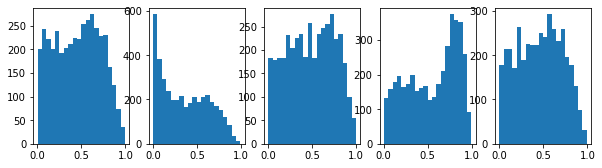

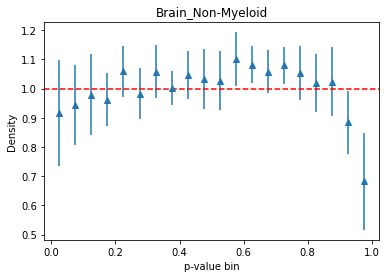

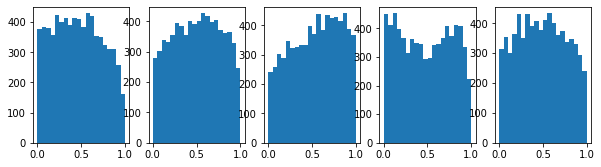

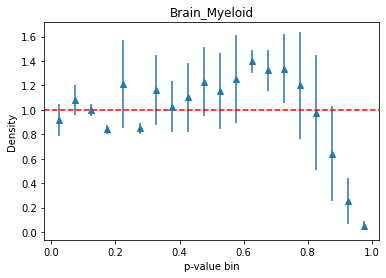

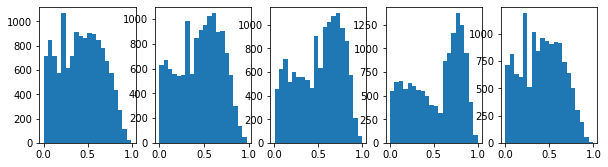

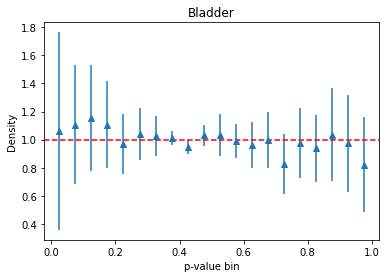

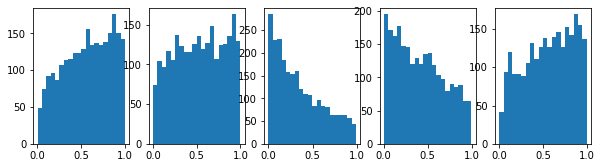

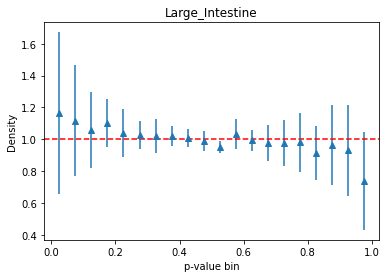

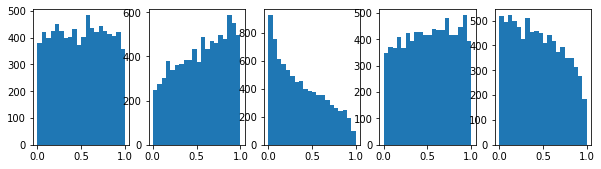

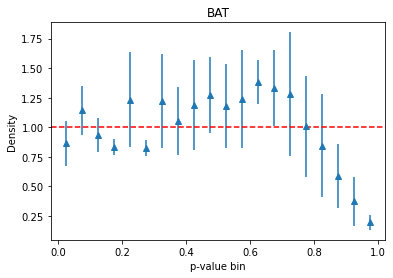

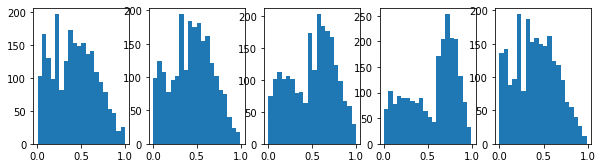

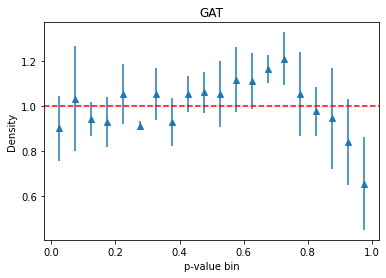

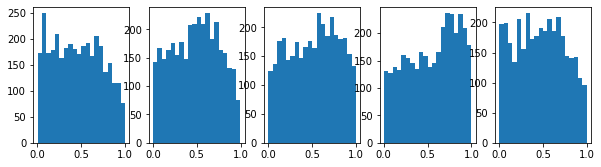

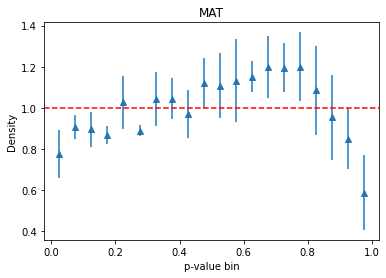

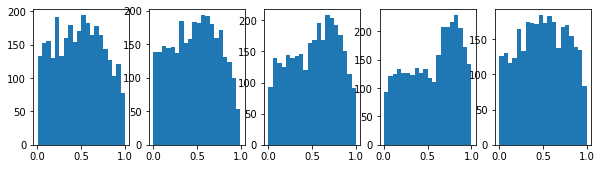

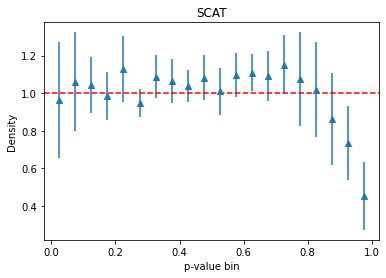

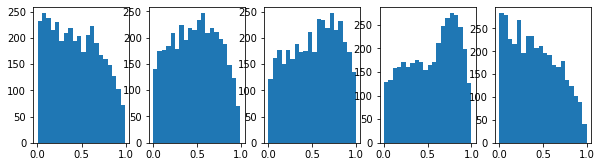

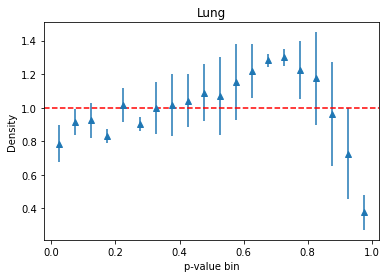

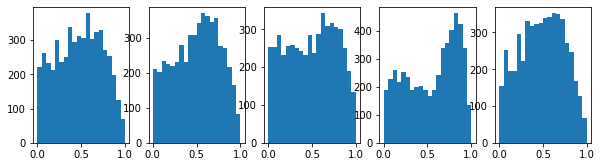

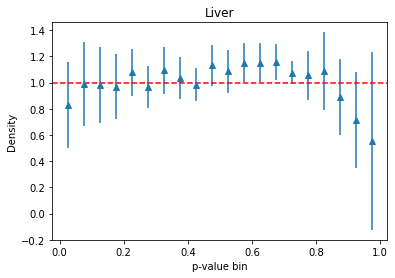

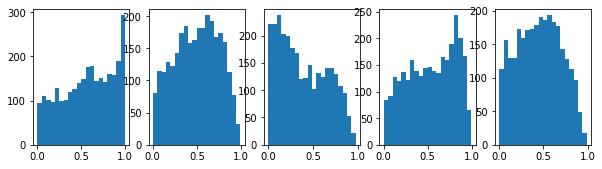

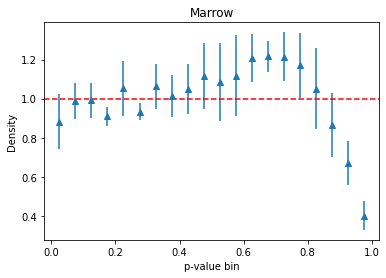

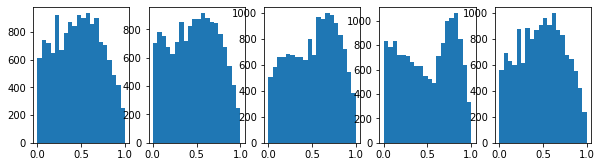

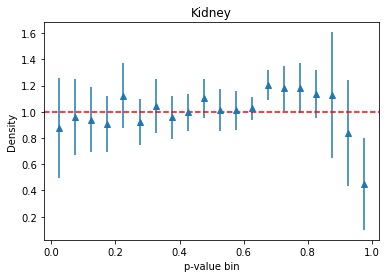

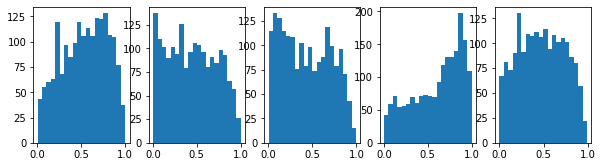

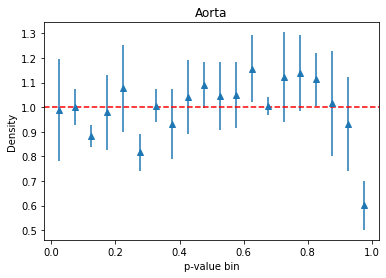

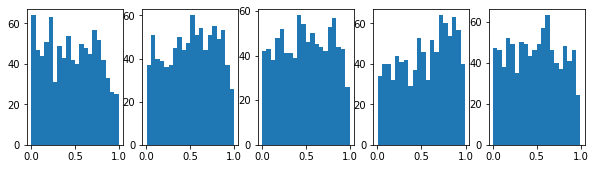

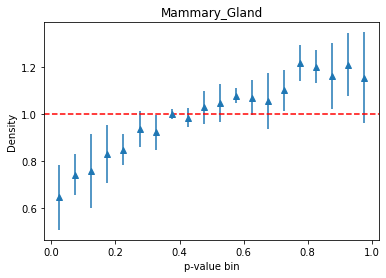

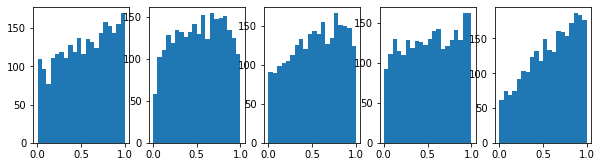

## high

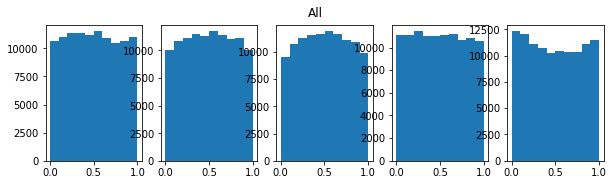

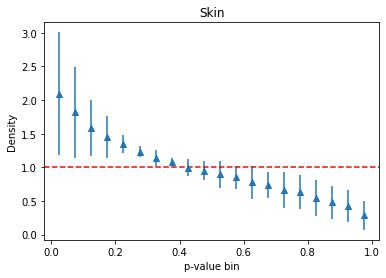

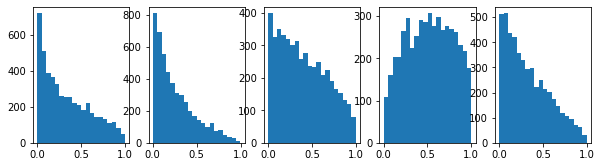

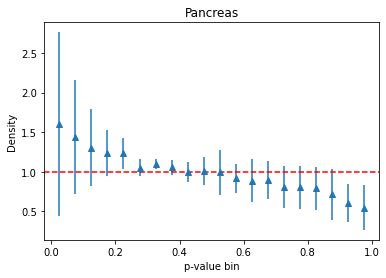

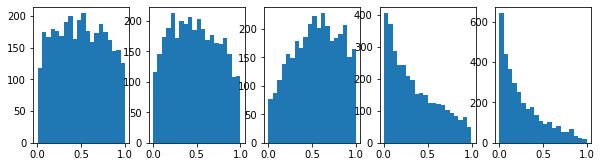

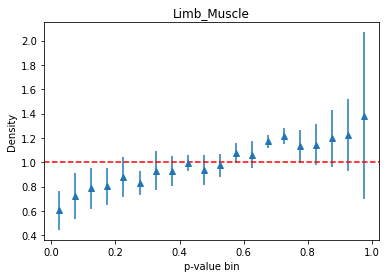

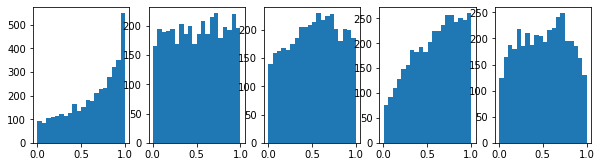

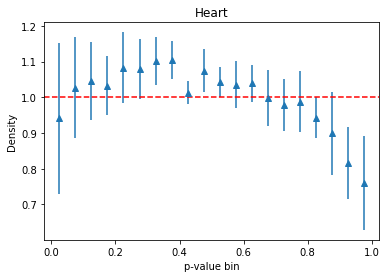

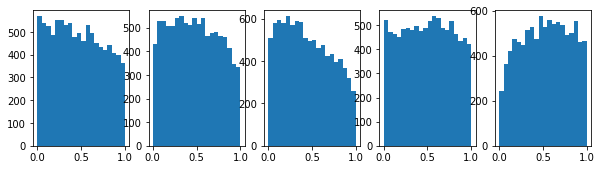

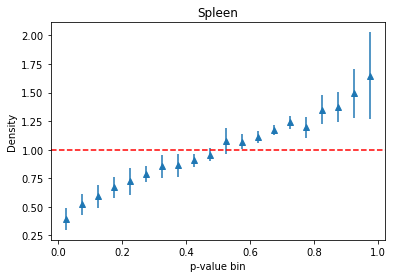

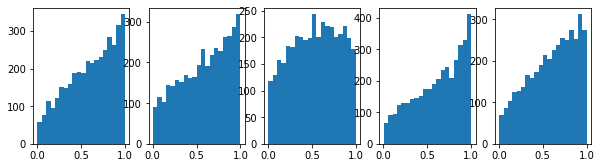

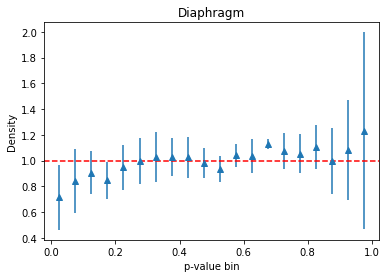

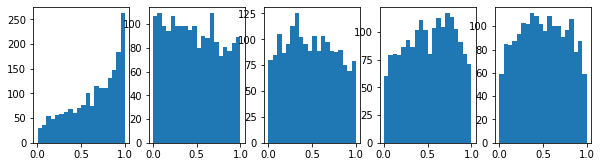

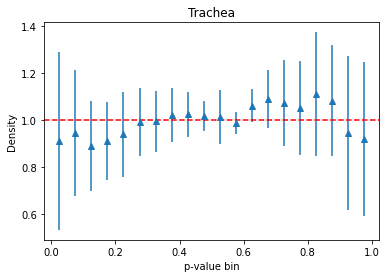

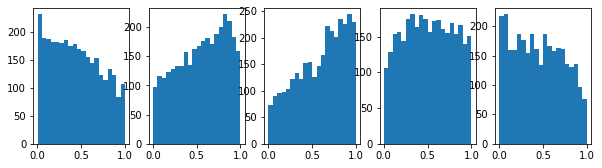

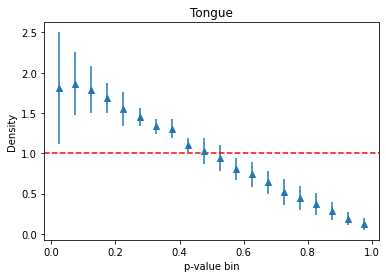

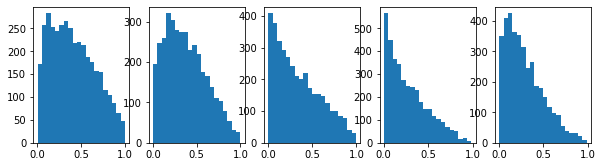

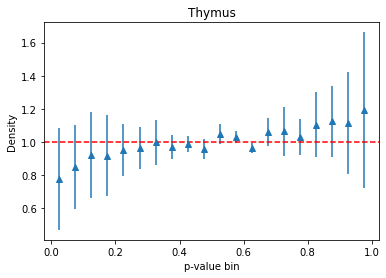

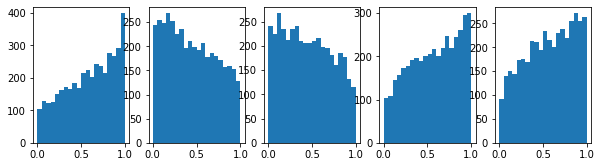

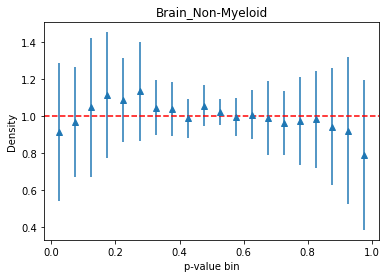

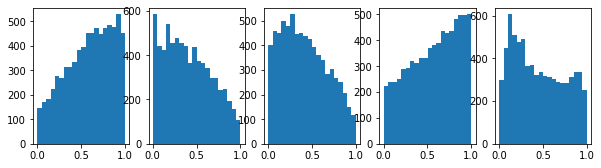

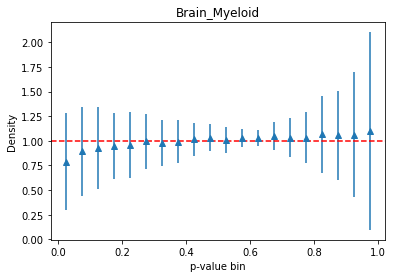

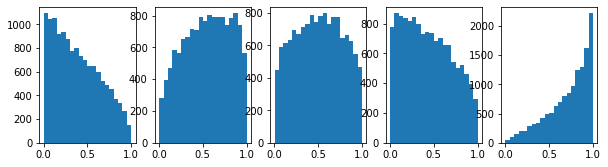

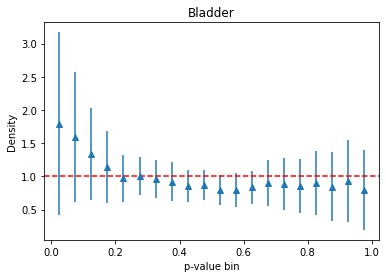

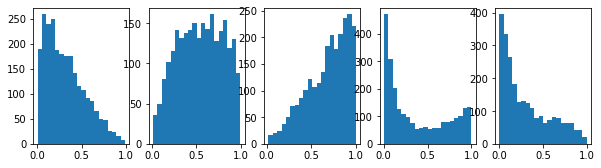

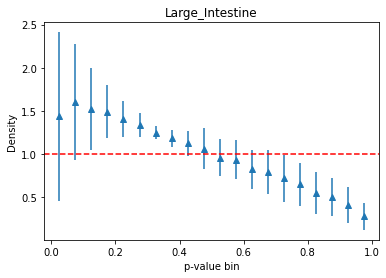

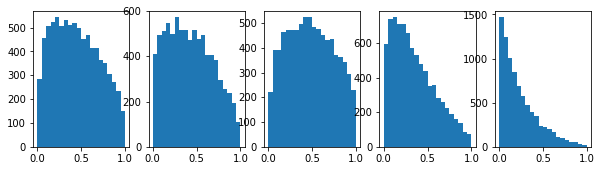

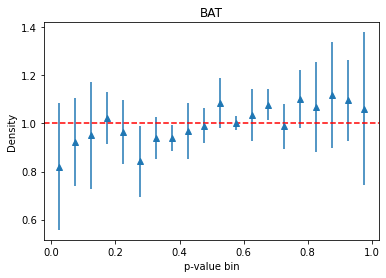

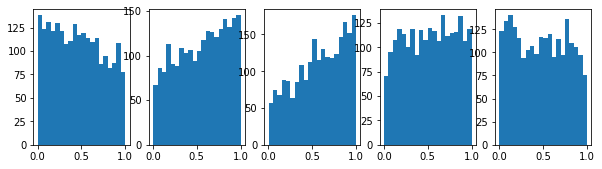

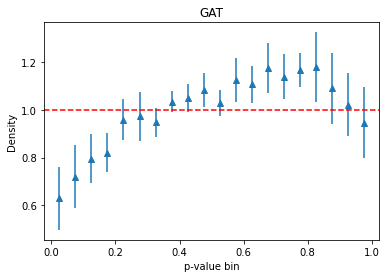

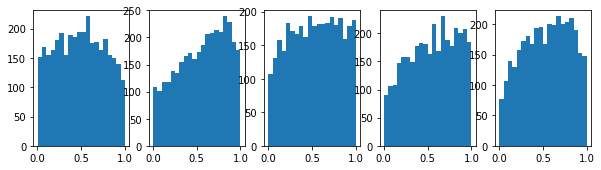

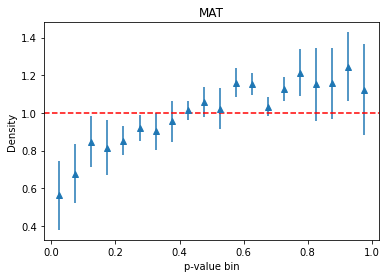

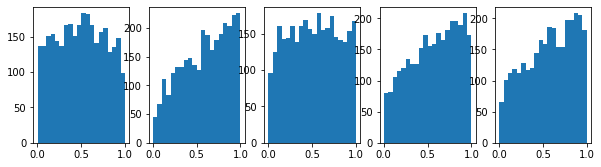

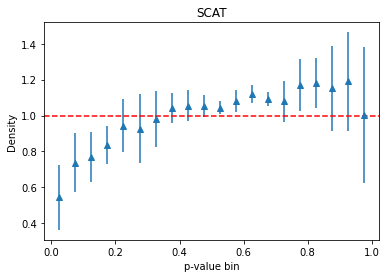

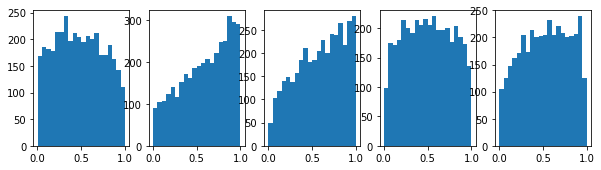

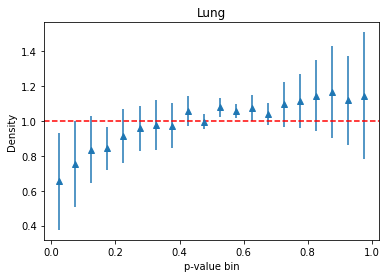

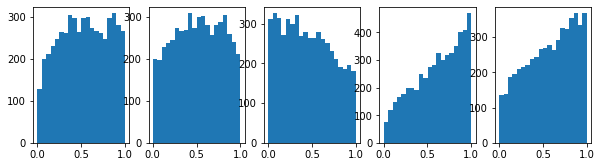

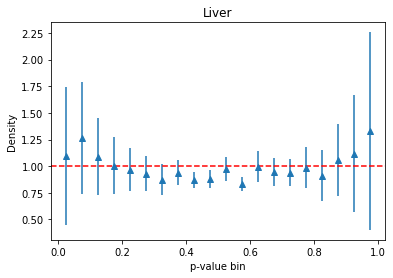

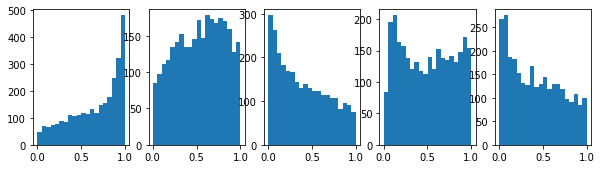

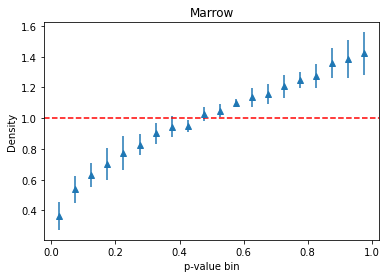

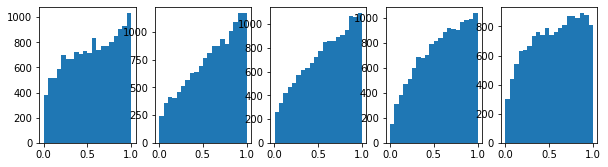

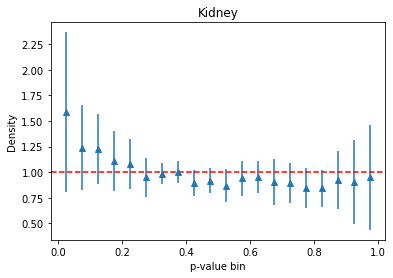

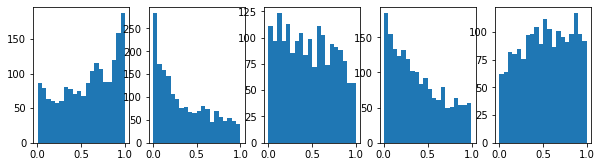

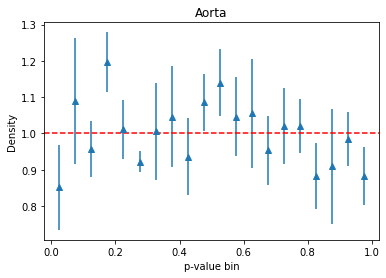

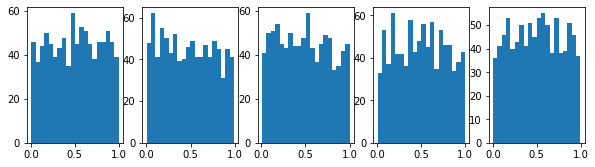

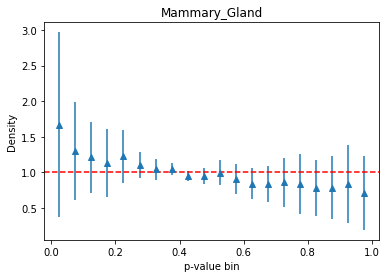

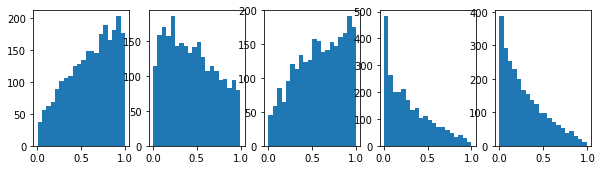

In [51]:
for group in [ 'random', 'low', 'high']:
    display(Markdown(f'## {group}'))
    pval_list = [job_dict[name].result()['pval'] for name in job_dict if group in name]
    plt.figure(figsize=(10, 2.5))
    for i in range(num_sim):
        plt.subplot(1, num_sim, i + 1)
        plt.hist(pval_list[i])
    plt.suptitle('All')
    plt.show()

    for tissue in data_facs_ct.obs['tissue'].unique():
        tissue_index = data_facs_ct.obs['tissue'] == tissue
        num_bins = 20
        plt.figure()
        hists = [np.histogram(pval_list[i][tissue_index], bins=num_bins, range=(0, 1), density=True)[0] for i in range(num_sim)]
        plt.errorbar(np.arange(0, 1, 1 / num_bins) + 0.5 / num_bins, 
                     np.mean(hists, axis=0), 
                     np.std(hists, axis=0) * 2 / np.sqrt(num_sim), 
                     linestyle='None', marker='^')
        plt.axhline(y=1., linestyle='--', color='r')
        plt.xlabel('p-value bin')
        plt.ylabel('Density')
        plt.title(tissue)
        plt.show()
        plt.figure(figsize=(10, 2.5))
        for sim_i in range(num_sim):
            plt.subplot(1, num_sim, sim_i + 1)
            plt.hist(pval_list[sim_i][tissue_index], bins=20)
        plt.show()
#         g = sns.pairplot(pd.DataFrame([pval_list[i][tissue_index] for i in range(num_sim)]).T, kind='reg', 
#             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.01}}, height=1.5)
#         g.fig.suptitle(tissue)

# Real data analysis

In [52]:
def load_gene_score(path, gene_id_col, score_col, ascending=True, num_genes=None, hsapiens_mmusculus_mapping=None):
    """load gene score from file and sort 
    Args:
        path: the file path to the gene score, in csv format
        gene_id_col: the column corresponding the gene identifier
        score_col: the column corresponding to the gene score
        ascending: whether to rank genes by score in ascending order
        convert_mmusculus: whether to convert to mmusculus gene symbols, input a dataframe if needed
        
    Returns:
        gene_score (pd.DataFrame): a dataframe with sorted scores
    """
    df = pd.read_csv(path, usecols=[gene_id_col, score_col])
    df.columns =['GENE', 'SCORE']
    if hsapiens_mmusculus_mapping is not None:
        df = pd.merge(df, hsapiens_mmusculus_mapping, left_on='GENE', right_on='hsapiens')[['mmusculus', 'SCORE']].rename(columns={'mmusculus': 'GENE'})
    df = df.sort_values('SCORE', ascending=ascending)
    if num_genes is not None:
        df = df.iloc[0 : num_genes, :].reset_index(drop=True)
    return df

def zsc2pval(zsc):
    return 1 - sp.stats.norm.cdf(zsc)


In [53]:
np.random.seed(1234)
gene_set_dict = dict()

## generate gene sets
trait_list = ['PASS_Schizophrenia_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018',
              'PASS_Alzheimers_Jansen2019', 
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 
              'PASS_LargeArteryStroke_Malik2018', 
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_IBD_deLange2017', 
              'PASS_Type_1_Diabetes', 
              'PASS_Type_2_Diabetes']

for trait in trait_list:
    # trait gene set
    trait_gene_df = load_gene_score(path=join(GENE_SCORE_PATH, 'gwas_max_abs_z', f'{trait}.csv'),
                     gene_id_col='GENE',
                     score_col='MAX_ABS_Z',
                     ascending=False,
                     num_genes=500,
                     hsapiens_mmusculus_mapping=hsapiens_mmusculus_mapping)

    gene_set_dict[trait] = np.unique(trait_gene_df.GENE.values)

for i in range(1, 6):
    gene_set_dict[f'random_{i}'] = np.unique(list(np.random.choice(data_facs_ct.var_names, size=500, replace=False)))

for name in gene_set_dict:
    gene_set_dict[name] = list(set(gene_set_dict[name]) & set(data_facs_ct.var_names))

In [54]:
import submitit
executor = submitit.AutoExecutor(folder="~/submitit_log/")
executor.update_parameters(timeout_min=25, mem_gb=20, slurm_partition="shared")
job_dict = {name: executor.submit(demo, 'all', 'all', 'own', gene_set_dict[name]) for name in gene_set_dict}

# PASS_Schizophrenia_Ruderfer2018          n_rej=308
# PASS_BipolarDisorder_Ruderfer2018        n_rej=0
# PASS_Alzheimers_Jansen2019               n_rej=0
# PASS_AdultOnsetAsthma_Ferreira2019       n_rej=1168
# PASS_Coronary_Artery_Disease             n_rej=0
# PASS_LargeArteryStroke_Malik2018         n_rej=3
# PASS_HDL                                 n_rej=776
# PASS_LDL                                 n_rej=355
# PASS_Rheumatoid_Arthritis                n_rej=4626
# PASS_Lupus                               n_rej=255
# PASS_IBD_deLange2017                     n_rej=4980
# PASS_Type_1_Diabetes                     n_rej=9
# PASS_Type_2_Diabetes                     n_rej=69
# random_1                                 n_rej=0
# random_2                                 n_rej=0
# random_3                                 n_rej=0
# random_4                                 n_rej=0
# random_5                                 n_rej=0


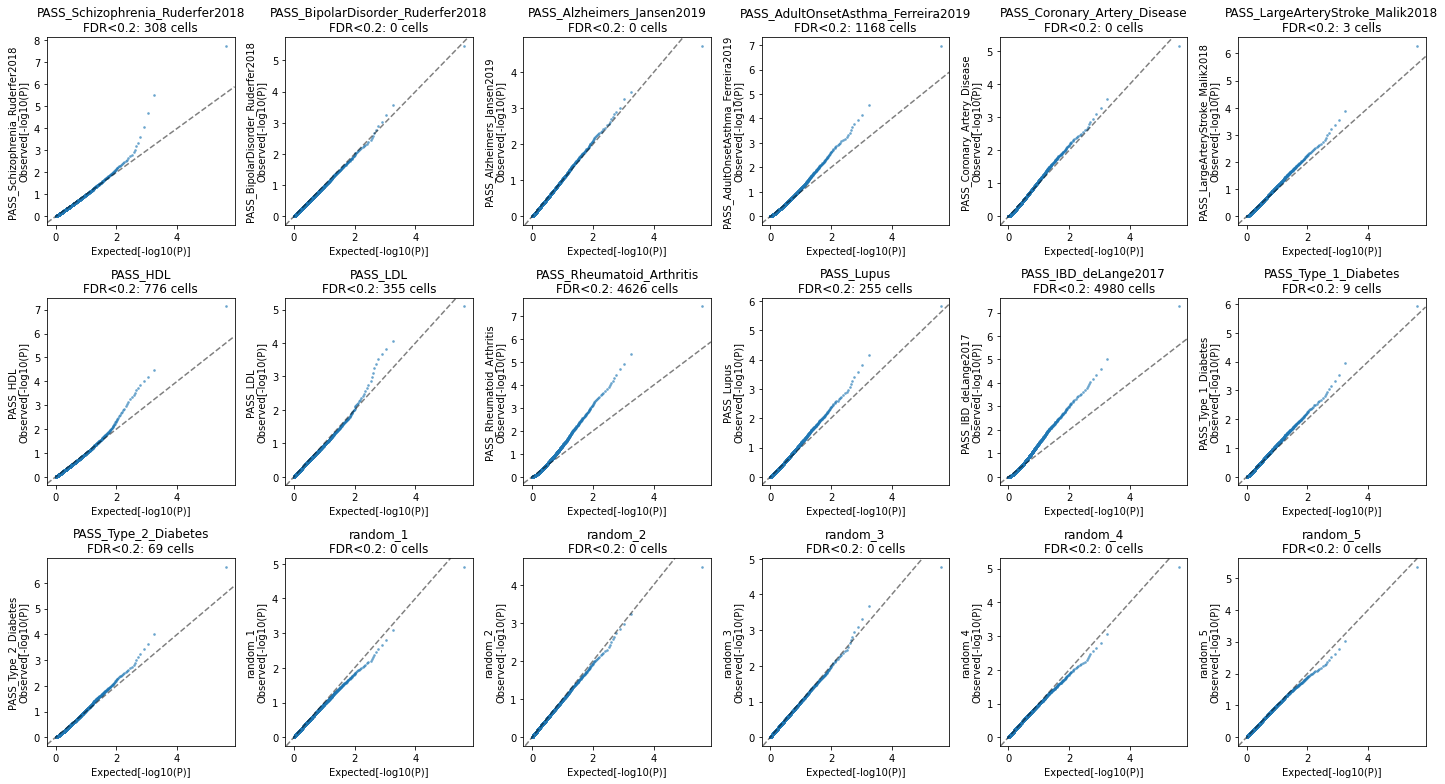

In [64]:
trait_ep_dict = dict()
trait_ez_dict = dict()
plot_trait_list = list(job_dict.keys())

num_cols = 6
normal_x = np.random.rand(10000)
normal_x = -np.log10(normal_x)

plt.figure(figsize=[20, 2+3*len(plot_trait_list)/num_cols])
for trait_i, trait in enumerate(plot_trait_list):
    if job_dict[trait].state != 'COMPLETED':
        continue
    trait_ep = job_dict[trait].result()['trait_ep']
    trait_ep_dict[trait] = trait_ep
    trait_ez = -sp.stats.norm.ppf(trait_ep).clip(min=-10,max=10)
    trait_ez_dict[trait] = trait_ez
    trait_fdr = multipletests(trait_ep, method='fdr_bh')[1]
    print('# %-40s n_rej=%d'%(trait, (trait_fdr<0.2).sum()))
    
    trait_logep = -np.log10(trait_ep_dict[trait])
    plt.subplot(int(np.ceil(len(plot_trait_list) / num_cols)), num_cols, trait_i + 1)
    util.qqplot(x=normal_x, y=trait_logep, quantiles=2000, s=3, alpha=0.5)
    plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
    
    plt.title('%s\nFDR<0.2: %d cells'%(trait,(trait_fdr<0.2).sum()))
    plt.ylabel('%s\nObserved[-log10(P)]'%trait)
    plt.xlabel('Expected[-log10(P)]')
plt.tight_layout()
plt.show()


In [65]:
# Find number of associated cells for each tissue/tissue_celltype
trait_list = list(job_dict.keys())
tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

dic_assoc = {'tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
             'tissue-celltype': pd.DataFrame(index=tc_list, columns=trait_list, data=0)}

df_obs = data_facs_ct.obs.copy()

for trait in trait_ep_dict:
    
    v_p = trait_ep_dict[trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    
    # tissue
    temp_df = df_obs.loc[v_fdr<0.2].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # tissue-cell
    temp_df = df_obs.loc[v_fdr<0.2].copy().copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

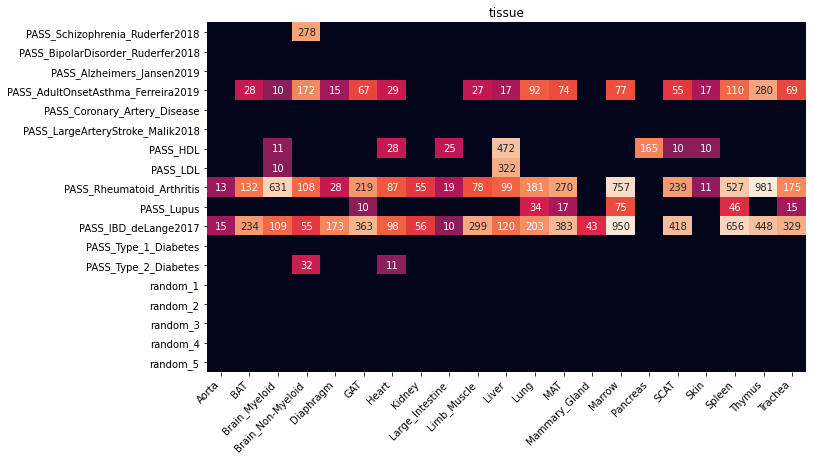

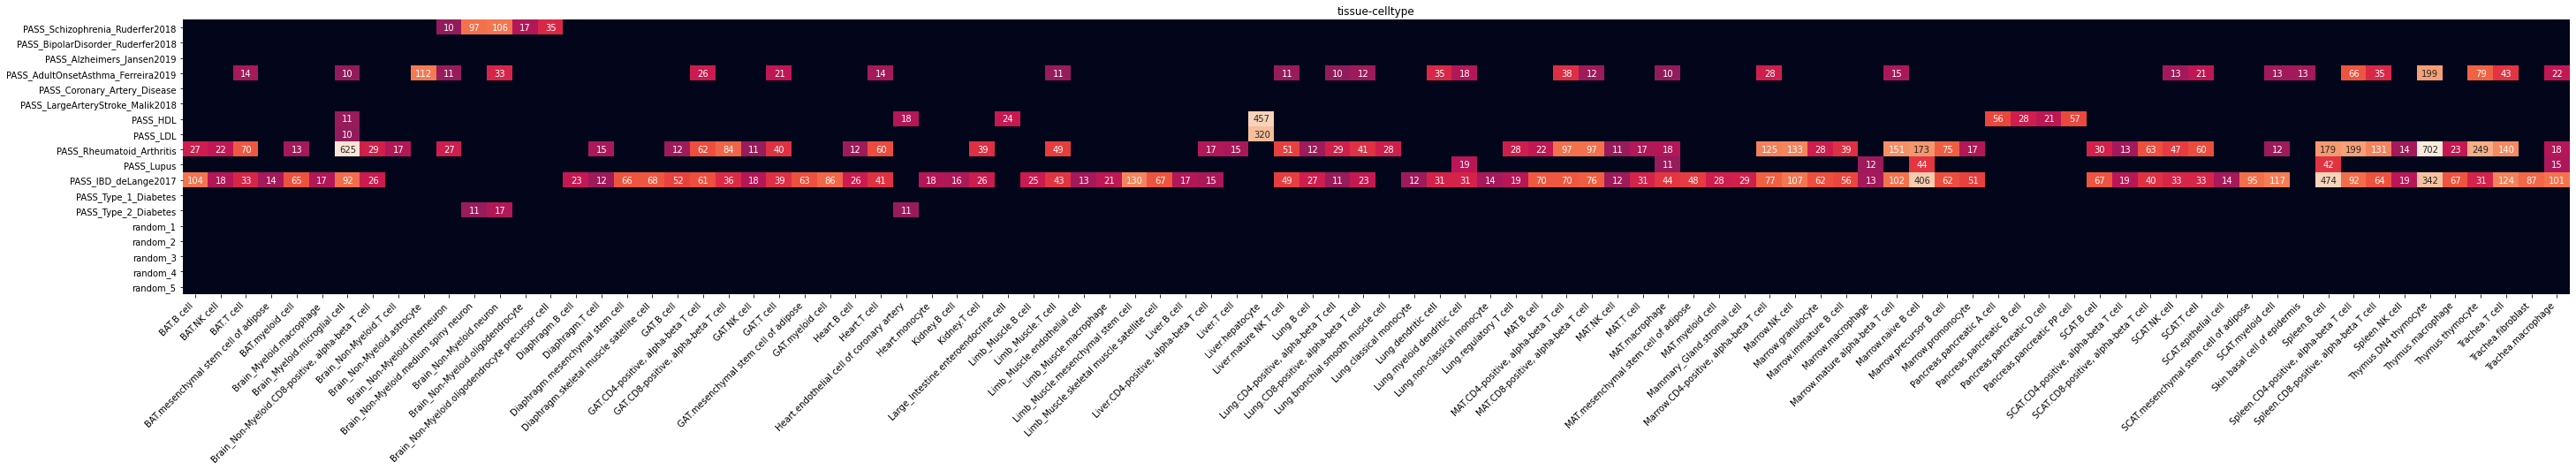

In [66]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>10]
    df_plot = df_plot.T
    df_plot[df_plot<10] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

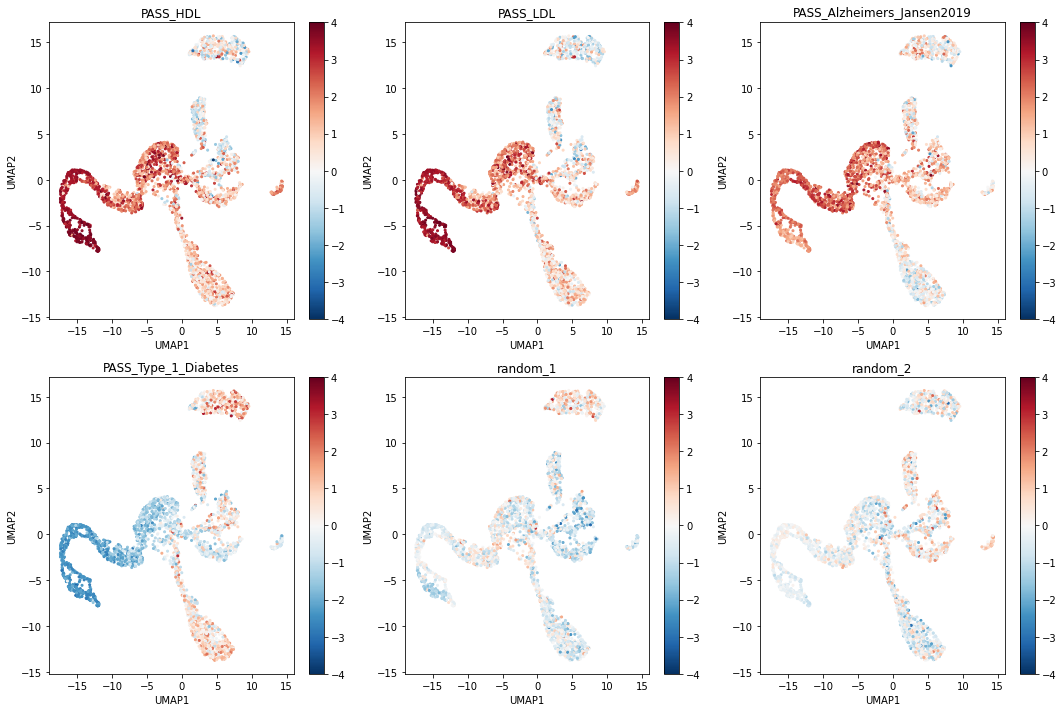

In [71]:
plot_list = [['Liver', 
              ['PASS_HDL', 'PASS_LDL', 'PASS_Alzheimers_Jansen2019',  'PASS_Type_1_Diabetes', 'random_1', 'random_2',]]]

for tissue, trait_plot_list in plot_list:
    
    adata_small = dic_data_facs[tissue].copy()    
    df_plot = pd.DataFrame(index=adata_small.obs.index)
    df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
    df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]
    
    # Trait TRS plot
    plt.figure(figsize=[15,10])
    for i_trait,trait in enumerate(trait_plot_list):
        
        plt.subplot(2,3,i_trait+1)
        temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
        temp_df[trait] = trait_ez_dict[trait]
        df_plot = df_plot.join(temp_df[trait])
            
        
        max_ = np.quantile(np.absolute(df_plot[trait].values), 0.99)
        min_ = np.quantile(np.absolute(df_plot[trait].values), 0.01)
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[trait],
                    cmap='RdBu_r', vmax=max_, vmin=-max_, s=4)
        plt.colorbar()
        plt.clim(-4,4)
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s'%trait)
        
    plt.tight_layout()
    plt.show()